In [1]:
import numpy as np
import networkx as nx
import sys

from sklearn import metrics
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%bash
wget -N http://snap.stanford.edu/data/facebook_combined.txt.gz
gunzip -f facebook_combined.txt.gz

--2017-07-18 02:43:58--  http://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

     0K .......... .......... .......... .......... .......... 23% 97,6K 2s
    50K .......... .......... .......... .......... .......... 46%  162K 1s
   100K .......... .......... .......... .......... .......... 70%  163K 0s
   150K .......... .......... .......... .......... .......... 93% 13,1M 0s
   200K .......... ...                                        100% 44,7K=1,4s

2017-07-18 02:44:01 (149 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]



In [3]:
def train_test_split_graph(G):
    trainG = nx.minimum_spanning_tree(G)
    diff = nx.difference(G, trainG)

    
    train, test = train_test_split(diff.edges(), test_size=G.number_of_edges()/2)
    
    trainG.add_edges_from(train)
    
    testG = nx.Graph()
    testG.add_edges_from(test)
    
    return trainG, testG

In [4]:
def generate_neg_edges(G, size):
    negEdges = set()

    while len(negEdges) < size:
        n1 = np.random.choice(G.nodes())
        n2 = np.random.choice(G.nodes())
        if not (G.has_edge(n1,n2) or n1 == n2):
            if n1<n2:
                negEdges.add((n1,n2))  
            else:
                negEdges.add((n2,n1))
    return negEdges

In [5]:
def get_n2v_model(G, walk_length=80, number_of_walks=10, d=128):
    
    walks =[]
    for i in range(number_of_walks):
        for node in G.nodes():
            walk = [node]
            next_node = node
            for j in range(walk_length):
                neigs = G.neighbors(next_node)
                if len(neigs) == 0:
                    break
                next_node = np.random.choice(neigs)
                walk.append(next_node)
            walks.append(walk)

    # Gensim needs str input
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=d, window=10, min_count=0, sg=1, workers=8, iter=1)
    
    return model

In [6]:
def get_edge_vectors(neg_edges, pos_edges, model):
    negs = [np.multiply(model[str(e[0])],model[str(e[1])]) for e in neg_edges]
    poss = [np.multiply(model[str(e[0])],model[str(e[1])]) for e in pos_edges]
    
    X = negs + poss
    Y = np.append(np.repeat(0, len(negs)), np.repeat(1, len(poss)))
    return X, Y

In [7]:
G = nx.read_edgelist('facebook_combined.txt')
trainG, testG = train_test_split_graph(G)

train_neg = generate_neg_edges(trainG, G.number_of_edges()/2)
test_neg = generate_neg_edges(G, G.number_of_edges()/2)

In [8]:
model = get_n2v_model(trainG)

In [9]:
X_train, Y_train = get_edge_vectors(trainG.edges(), train_neg, model)
X_test, Y_test = get_edge_vectors(testG.edges(), test_neg, model)

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
regr.score(X_test, Y_test) 

0.81461047642428364

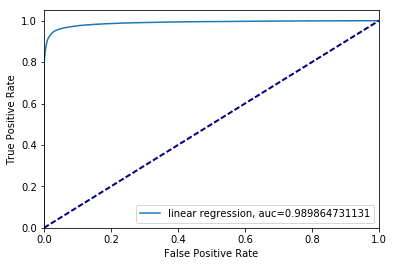

In [10]:
pred = regr.predict(X_test)
auc = metrics.roc_auc_score(Y_test, pred)
fpr, tpr, thresh = metrics.roc_curve(Y_test, pred)


plt.plot(fpr,tpr,label="linear regression, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc=4)